# Going Deeper(CV)_DG
## 이미지 어디까지 우려볼까?

In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import random
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터 불러오기 
- stanford_dogs 사용
- 여러 강아지의 종류를 가지고 있는 데이터셋


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


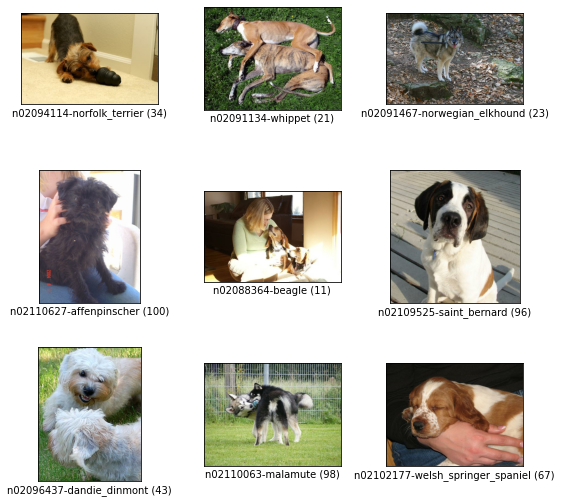

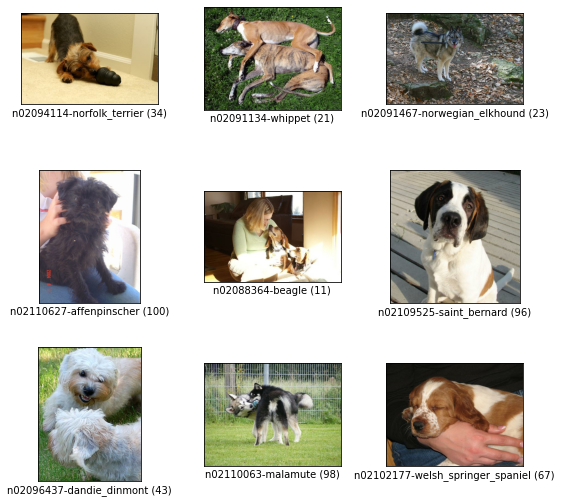

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)

- augmentation 적용하기 (이미지 우려내기)

많은 augmentation 기법들이 있지만 그중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

random_brightness()  
random_contrast()  
random_crop()  
random_flip_left_right()  
random_flip_up_down()  
random_hue()  
random_jpeg_quality()  
random_saturation()  
그럼 Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

```def 전처리_함수(image, label):   # 변환할 이미지와 라벨  
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label```

In [8]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

- class 개수

In [9]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

- onehot encoding 을 위한 def

In [11]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False,with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## 1.3. CutMix

- 이미지의 일정 영역을 잘라서 다른 이미지에 붙여주는 방법
- 섞인 이미지의 전체 이미지 대비 비율을 계산하고, 면적에 비례해서 두 라벨을 섞어준다.

가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

아래 코드 블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만들어 보세요! 이미지를 텐서로 만들어 텐서플로우 연산을 사용해 봅시다. 이때 이미지는 tfds에서 한 장을 뽑아서 사용해 보세요.

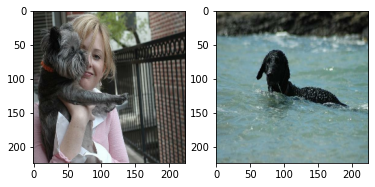

In [14]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [15]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


- 배치 내의 이미지를 두 개 골라 바운딩 박스의 위치를 랜덤하게 뽑는 함수

In [16]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(66, shape=(), dtype=int32) tf.Tensor(190, shape=(), dtype=int32)
y :  tf.Tensor(62, shape=(), dtype=int32) tf.Tensor(209, shape=(), dtype=int32)


In [17]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

- 잘라낸 영역과 이미지를 합쳐주는 함수 

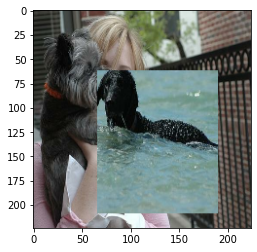

In [18]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [19]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


In [20]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.36328125, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

- 가진 영역만큼 이미지의 라벨이 정해진다. 

In [21]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Mixup
- 비율을 일정한 범위 내에서 랜덤하게 뽑는다. 비율값에 따라 두 이미지의 픽셀값과 라벨을 섞어준다.

In [22]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


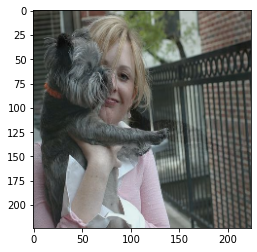

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.14865851 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [23]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [24]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [25]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# 모델 학습

1. no aug, aug , cutmix , mixup 비교 
2. cutmix,mixup를 random하게 실행한 데이터셋과 비교
3. 어그멘테이션을 하지 않은 상태로 10epochs를 진행한 뒤 cutmix와 mixup 데이터셋으로 학습해보기
    - 인간도 기본적인 인식이 있는 상태에서 cutmix나 mixup과 같은 특별한 형태를 구별하니, 그것과 비슷하게 적용해봄  

batchsize =16 

In [21]:
num_classes = ds_info.features["label"].num_classes
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
#Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
mixup_resnet50 =  keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

cutmix_resnet50 =  keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [22]:
EPOCH = 20  # Augemtation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)
no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [48]:
history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 157s 201ms/step - loss: 2.2144 - accuracy: 0.4423 - val_loss: 2.9701 - val_accuracy: 0.2661
Epoch 2/20
750/750 [==============================] - 169s 225ms/step - loss: 0.7886 - accuracy: 0.7822 - val_loss: 1.1002 - val_accuracy: 0.6818
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2504 - accuracy: 0.9451 - val_loss: 0.9770 - val_accuracy: 0.7158
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0699 - accuracy: 0.9925 - val_loss: 0.9017 - val_accuracy: 0.7408
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0267 - accuracy: 0.9993 - val_loss: 0.9237 - val_accuracy: 0.7425
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0181 - accuracy: 0.9996 - val_loss: 0.9765 - val_accuracy: 0.7326
Epoch 7/20
750/750 [==============================] - 170s 226ms/step - loss: 0.0260 - accuracy: 0.9986 - val_loss: 0.9575 -

In [49]:
df_history_no_aug_resnet50 = pd.DataFrame({
    'train_loss': history_no_aug_resnet50.history['loss'],
    'val_acc': history_no_aug_resnet50.history['val_accuracy']
    })
df_history_no_aug_resnet50.to_csv('./history_no_aug_resnet50.csv', index=False)

In [39]:
history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 207ms/step - loss: 2.2706 - accuracy: 0.4314 - val_loss: 3.1009 - val_accuracy: 0.2503
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 0.9317 - accuracy: 0.7344 - val_loss: 1.1832 - val_accuracy: 0.6507
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 0.4857 - accuracy: 0.8681 - val_loss: 1.2376 - val_accuracy: 0.6431
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 0.2672 - accuracy: 0.9345 - val_loss: 1.2117 - val_accuracy: 0.6687
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 0.1418 - accuracy: 0.9714 - val_loss: 1.0373 - val_accuracy: 0.7073
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0847 - accuracy: 0.9867 - val_loss: 0.9717 - val_accuracy: 0.7259
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0500 - accuracy: 0.9945 - val_loss: 0.9762 -

In [40]:
df_history_aug_resnet50 = pd.DataFrame({
    'train_loss': history_aug_resnet50.history['loss'],
    'val_acc': history_aug_resnet50.history['val_accuracy']
    })
df_history_no_aug_resnet50.to_csv('./history_aug_resnet50.csv', index=False)

In [41]:
history_cutmix_resnet50= cutmix_resnet50.fit(
    ds_train_cutmix, # ds_train_cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 208ms/step - loss: 3.8211 - accuracy: 0.2171 - val_loss: 3.2694 - val_accuracy: 0.2197
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 2.9529 - accuracy: 0.4317 - val_loss: 1.4760 - val_accuracy: 0.5917
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 2.6372 - accuracy: 0.5299 - val_loss: 1.3000 - val_accuracy: 0.6362
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 2.4428 - accuracy: 0.5893 - val_loss: 1.3209 - val_accuracy: 0.6403
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2716 - accuracy: 0.6513 - val_loss: 1.1282 - val_accuracy: 0.6799
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 2.1711 - accuracy: 0.6785 - val_loss: 1.4014 - val_accuracy: 0.6272
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 2.0744 - accuracy: 0.7080 - val_loss: 1.1995 -

In [27]:
df_history_cutmix_resnet50 = pd.DataFrame({
    'train_loss': history_cutmix_resnet50.history['loss'],
    'val_acc': history_cutmix_resnet50.history['val_accuracy']
    })
df_history_cutmix_resnet50.to_csv('./history_cutmix_resnet50.csv', index=False)

In [26]:
history_mixup_resnet50= mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 191s 205ms/step - loss: 3.8365 - accuracy: 0.2074 - val_loss: 3.2243 - val_accuracy: 0.2199
Epoch 2/20
750/750 [==============================] - 156s 207ms/step - loss: 2.9767 - accuracy: 0.4228 - val_loss: 1.3767 - val_accuracy: 0.6152
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 2.6440 - accuracy: 0.5258 - val_loss: 1.3789 - val_accuracy: 0.6230
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 2.4359 - accuracy: 0.5937 - val_loss: 1.3457 - val_accuracy: 0.6299
Epoch 5/20
750/750 [==============================] - 156s 207ms/step - loss: 2.2875 - accuracy: 0.6398 - val_loss: 1.2821 - val_accuracy: 0.6476
Epoch 6/20
750/750 [==============================] - 156s 207ms/step - loss: 2.1586 - accuracy: 0.6867 - val_loss: 1.3311 - val_accuracy: 0.6425
Epoch 7/20
750/750 [==============================] - 156s 207ms/step - loss: 2.0619 - accuracy: 0.7175 - val_loss: 1.1751 -

In [28]:
df_history_mixup_resnet50 = pd.DataFrame({
    'train_loss': history_mixup_resnet50.history['loss'],
    'val_acc': history_mixup_resnet50.history['val_accuracy']
    })
df_history_mixup_resnet50.to_csv('./history_mixup_resnet50.csv', index=False)

In [4]:
history_no_aug_resnet50 = pd.read_csv('./history_no_aug_resnet50.csv')
history_aug_resnet50 = pd.read_csv('./history_aug_resnet50.csv')
history_cutmix_resnet50= pd.read_csv('./history_cutmix_resnet50.csv')
history_mixup_resnet50 = pd.read_csv('./history_mixup_resnet50.csv')

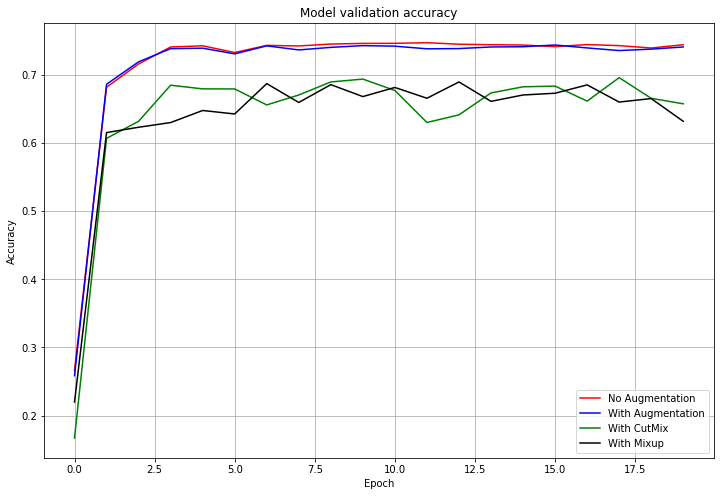

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(history_no_aug_resnet50['val_acc'], 'r')
plt.plot(history_aug_resnet50['val_acc'], 'b')
plt.plot(history_cutmix_resnet50['val_acc'], 'g')
plt.plot(history_mixup_resnet50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

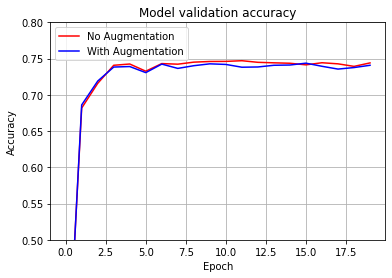

In [37]:
plt.plot(history_no_aug_resnet50['val_acc'], 'r')
plt.plot(history_aug_resnet50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

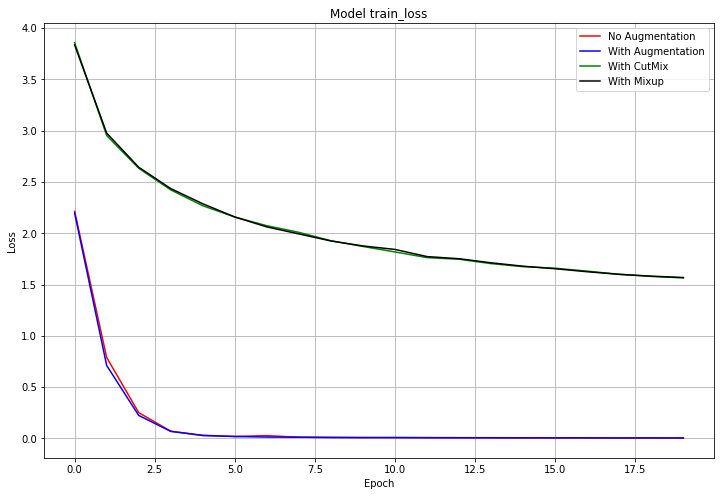

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(history_no_aug_resnet50['train_loss'], 'r')
plt.plot(history_aug_resnet50['train_loss'], 'b')
plt.plot(history_cutmix_resnet50['train_loss'], 'g')
plt.plot(history_mixup_resnet50['train_loss'], 'k')
plt.title('Model train_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

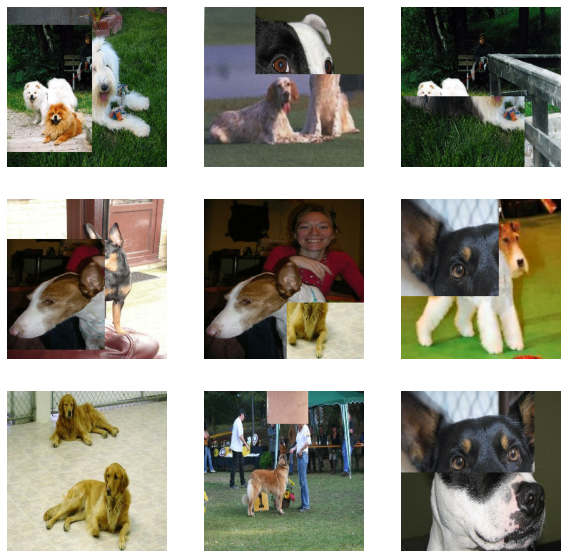

In [26]:
#cutmix 확인
plt.figure(figsize=(10, 10))
for images, labels in ds_train_cutmix .take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")


## 결과 1 
- cutmix는 성능 압도적으로 좋지않았고 mixup은 좋았다.
- 아마 cutmix는 위와 같이 제대로 잘리지 않은 경우 (개의 형태가 안잘렸는데 mix가 되는 경우) 일때 학습이 잘안되는것같다.
- augmentaiton을 한 것이 성능이 가장 좋았다. 안한것보단 나아보인다. 

In [27]:
def cutmix_random(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    switch = random.randrange(1,7)
    if switch>=3:
        for i in range(batch_size):
            image_a = image[i]
            label_a = label[i]
            j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
            image_b = image[j]
            label_b = label[j]
            x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
            mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
            mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

        mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
        mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
        return mixed_imgs, mixed_labels
    else:
        label = tf.one_hot(label, num_classes)
        return image, label


In [28]:
def mixup_random(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    switch = random.randrange(1,7)
    if switch>=2 :
        for i in range(batch_size):
            image_a = image[i]
            label_a = label[i]
            j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
            image_b = image[j]
            label_b = label[j]
            mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
            mixed_imgs.append(mixed_img)
            mixed_labels.append(mixed_label)

        mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
        mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
        return mixed_imgs, mixed_labels
    else :
        label = tf.one_hot(label, num_classes)
        return image, label

- cutmix와 mixup을 랜덤하게 해주는 함수를 간단히 만들어 원본을 약간 남겨보자라는 생각이 들어 만들었다.

In [29]:
#mixup_random 
ds = ds_train.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
ds= ds.batch(16)
ds_mixup_rand= ds.map(
        mixup_random,
         num_parallel_calls=2
        )

ds_mixup_rand = ds_mixup_rand.repeat()
ds_mixup_rand = ds_mixup_rand.shuffle(200)
ds_mixup_rand= ds_mixup_rand.prefetch(tf.data.experimental.AUTOTUNE)


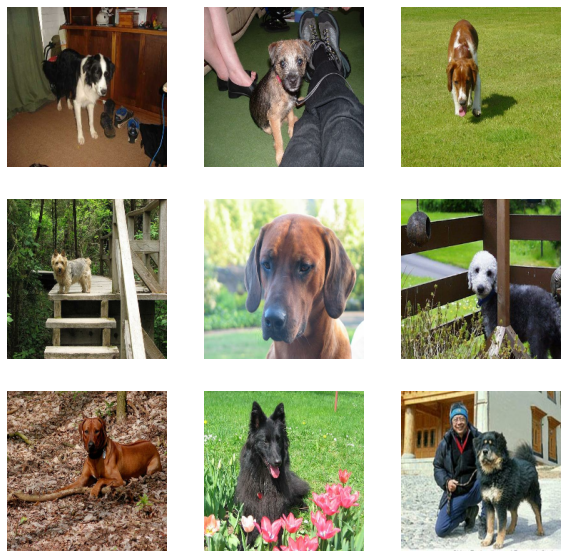

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in ds_mixup_rand.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [31]:
ds_cutmix_rand= ds.map(
        cutmix_random,
         num_parallel_calls=2
        )

ds_cutmix_rand = ds_cutmix_rand.repeat()
ds_cutmix_rand = ds_cutmix_rand.shuffle(200)
ds_cutmix_rand= ds_cutmix_rand.prefetch(tf.data.experimental.AUTOTUNE)

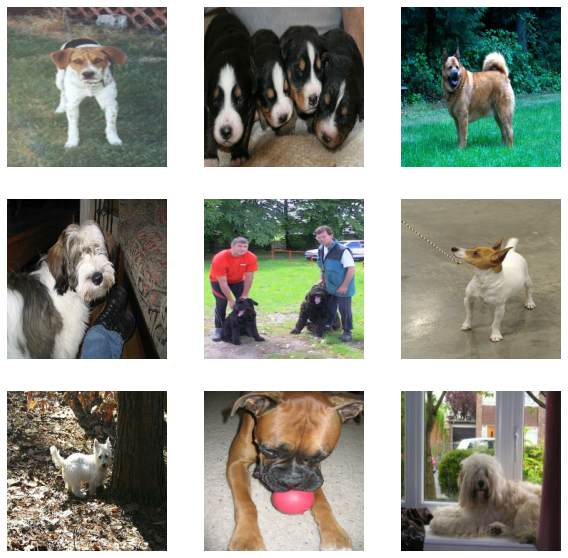

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in ds_cutmix_rand.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

- 데이터셋을 만들고 확인해봤다.
- CUTMIX, MIXUP가 랜덤하게 되어지는 모습을 확인가능

In [33]:
rand_cutmix_resnet50 =  keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
rand_mixup_resnet50 =  keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
no_aug_10_cutmix_10 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
no_aug_10_mixup_10 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


94781440/94765736 [==============================] - 1s 0us/step


In [34]:
rand_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

rand_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

no_aug_10_cutmix_10.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
no_aug_10_mixup_10.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [44]:
EPOCH = 20
history_rand_cutmix_resnet50= rand_cutmix_resnet50.fit(
    ds_cutmix_rand, # ds_train_cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 176s 225ms/step - loss: 3.8364 - accuracy: 0.2137 - val_loss: 3.3632 - val_accuracy: 0.2162
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 2.9358 - accuracy: 0.4324 - val_loss: 1.2821 - val_accuracy: 0.6346
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 2.6170 - accuracy: 0.5393 - val_loss: 1.2721 - val_accuracy: 0.6470
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 2.4199 - accuracy: 0.6037 - val_loss: 1.1809 - val_accuracy: 0.6758
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 2.2893 - accuracy: 0.6480 - val_loss: 1.2653 - val_accuracy: 0.6533
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 2.1375 - accuracy: 0.6911 - val_loss: 1.2042 - val_accuracy: 0.6813
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 2.0577 - accuracy: 0.7153 - val_loss: 1.2002 -

In [45]:
df_history_rand_cutmix_resnet50 = pd.DataFrame({
    'train_loss': history_rand_cutmix_resnet50.history['loss'],
    'val_acc': history_rand_cutmix_resnet50.history['val_accuracy']
    })
df_history_rand_cutmix_resnet50.to_csv('./history_rand_cutmix_resnet50.csv', index=False)

In [35]:
EPOCH = 20  
history_rand_mixup_resnet50= rand_mixup_resnet50.fit(
    ds_mixup_rand, # ds_train_cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 184s 195ms/step - loss: 2.1934 - accuracy: 0.4526 - val_loss: 3.7620 - val_accuracy: 0.1597
Epoch 2/20
750/750 [==============================] - 150s 201ms/step - loss: 0.7822 - accuracy: 0.7825 - val_loss: 1.1582 - val_accuracy: 0.6655
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2667 - accuracy: 0.9393 - val_loss: 0.9338 - val_accuracy: 0.7284
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1015 - accuracy: 0.9869 - val_loss: 0.9212 - val_accuracy: 0.7310
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0348 - accuracy: 0.9980 - val_loss: 0.8998 - val_accuracy: 0.7450
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0174 - accuracy: 0.9998 - val_loss: 0.9111 - val_accuracy: 0.7436
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0118 - accuracy: 0.9999 - val_loss: 0.9210 -

In [36]:
df_history_rand_mixup_resnet50 = pd.DataFrame({
    'train_loss': history_rand_mixup_resnet50.history['loss'],
    'val_acc': history_rand_mixup_resnet50.history['val_accuracy']
    })
df_history_rand_mixup_resnet50.to_csv('./history_rand_mixup_resnet50.csv', index=False)

In [37]:
history_rand_cutmix_resnet50 = pd.read_csv('./history_rand_cutmix_resnet50.csv')
history_rand_mixup_resnet50 = pd.read_csv('./history_rand_mixup_resnet50.csv')

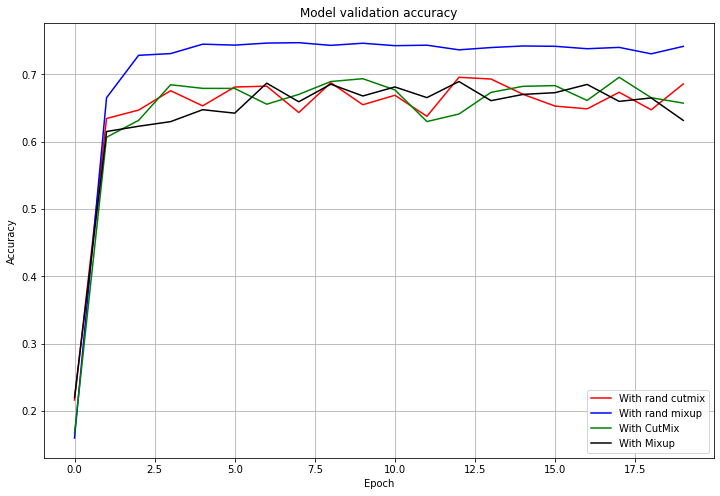

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(history_rand_cutmix_resnet50 ['val_acc'], 'r')
plt.plot(history_rand_mixup_resnet50['val_acc'], 'b')
plt.plot(history_cutmix_resnet50['val_acc'], 'g')
plt.plot(history_mixup_resnet50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With rand cutmix', 'With rand mixup', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

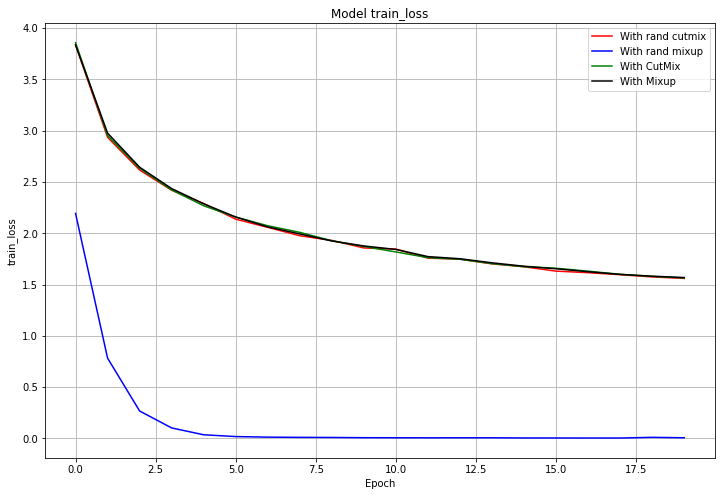

In [40]:
plt.figure(figsize=(12, 8))
plt.plot(history_rand_cutmix_resnet50 ['train_loss'], 'r')
plt.plot(history_rand_mixup_resnet50['train_loss'], 'b')
plt.plot(history_cutmix_resnet50['train_loss'], 'g')
plt.plot(history_mixup_resnet50['train_loss'], 'k')
plt.title('Model train_loss')
plt.ylabel('train_loss')
plt.xlabel('Epoch')
plt.legend(['With rand cutmix', 'With rand mixup', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

In [45]:
EPOCH = 10  
history_no_aug_10_cutmix_10= no_aug_10_cutmix_10.fit(
    ds_train_no_aug, # ds_train_cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
EPOCH = 20 
history_no_aug_10_cutmix_10= no_aug_10_cutmix_10.fit(
    ds_cutmix_rand, # ds_train_cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)



Epoch 1/10
750/750 [==============================] - 153s 196ms/step - loss: 2.2052 - accuracy: 0.4473 - val_loss: 3.4913 - val_accuracy: 0.1869
Epoch 2/10
750/750 [==============================] - 151s 201ms/step - loss: 0.7144 - accuracy: 0.8071 - val_loss: 1.2114 - val_accuracy: 0.6567
Epoch 3/10
750/750 [==============================] - 153s 203ms/step - loss: 0.2321 - accuracy: 0.9537 - val_loss: 0.9691 - val_accuracy: 0.7172
Epoch 4/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0684 - accuracy: 0.9927 - val_loss: 0.9514 - val_accuracy: 0.7267
Epoch 5/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0278 - accuracy: 0.9991 - val_loss: 0.9340 - val_accuracy: 0.7382
Epoch 6/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0175 - accuracy: 0.9996 - val_loss: 0.9472 - val_accuracy: 0.7392
Epoch 7/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0134 - accuracy: 0.9994 - val_loss: 0.9750 -

In [50]:
df_history_no_aug_10_cutmix_20= pd.DataFrame({
    'train_loss': history_no_aug_10_cutmix_10.history['loss'],
    'val_acc': history_no_aug_10_cutmix_10.history['val_accuracy']
    })
df_history_no_aug_10_cutmix_20.to_csv('./history_no_aug_10_cutmix_20.csv', index=False)

In [31]:
 EPOCH = 10  
history_no_aug_10_mixup_10= no_aug_10_mixup_10.fit(
    ds_train_no_aug, # ds_train_cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
EPOCH=20
history_no_aug_10_mixup_10= no_aug_10_mixup_10.fit(
    ds_mixup_rand, # ds_train_cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 189s 200ms/step - loss: 2.1883 - accuracy: 0.4523 - val_loss: 3.6369 - val_accuracy: 0.1679
Epoch 2/10
750/750 [==============================] - 153s 205ms/step - loss: 0.7016 - accuracy: 0.8103 - val_loss: 1.0932 - val_accuracy: 0.6810
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 0.2288 - accuracy: 0.9518 - val_loss: 0.9373 - val_accuracy: 0.7276
Epoch 4/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0632 - accuracy: 0.9946 - val_loss: 0.9082 - val_accuracy: 0.7395
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0280 - accuracy: 0.9989 - val_loss: 0.9100 - val_accuracy: 0.7444
Epoch 6/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0177 - accuracy: 0.9993 - val_loss: 0.9140 - val_accuracy: 0.7443
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0128 - accuracy: 0.9996 - val_loss: 0.9276 -

In [32]:
df_history_no_aug_10_mixup_10= pd.DataFrame({
    'train_loss': history_no_aug_10_mixup_10.history['loss'],
    'val_acc': history_no_aug_10_mixup_10.history['val_accuracy']
    })
df_history_no_aug_10_mixup_10.to_csv('./history_no_aug_10_mixup_20.csv', index=False)

In [51]:
history_no_aug_10_cutmix_20 = pd.read_csv('./history_no_aug_10_cutmix_20.csv')
history_no_aug_10_mixup_20= pd.read_csv('./history_no_aug_10_mixup_20.csv')

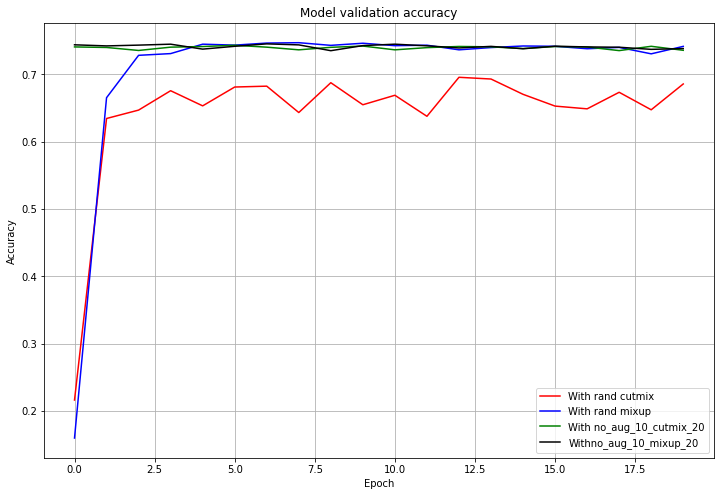

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(history_rand_cutmix_resnet50 ['val_acc'], 'r')
plt.plot(history_rand_mixup_resnet50['val_acc'], 'b')
plt.plot(history_no_aug_10_cutmix_20['val_acc'], 'g')
plt.plot(history_no_aug_10_mixup_20['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With rand cutmix', 'With rand mixup', 'With no_aug_10_cutmix_20', 'Withno_aug_10_mixup_20'], loc='lower right')
plt.grid(True)
plt.show()

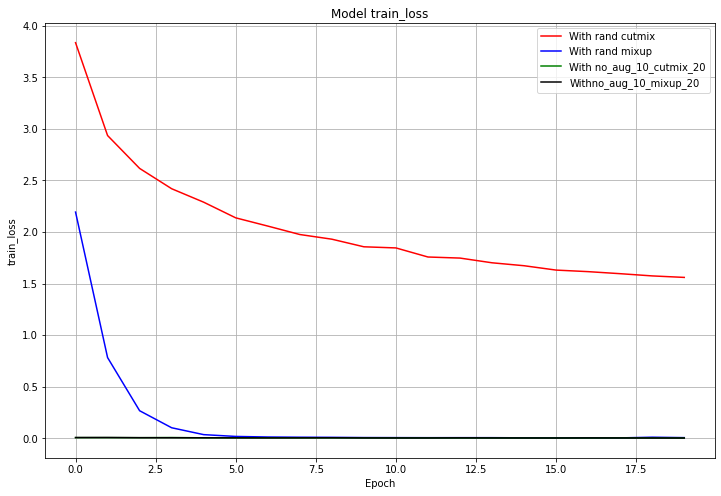

In [53]:
plt.figure(figsize=(12, 8))
plt.plot(history_rand_cutmix_resnet50 ['train_loss'], 'r')
plt.plot(history_rand_mixup_resnet50['train_loss'], 'b')
plt.plot(history_no_aug_10_cutmix_20['train_loss'], 'g')
plt.plot(history_no_aug_10_mixup_20['train_loss'], 'k')
plt.title('Model train_loss')
plt.ylabel('train_loss')
plt.xlabel('Epoch')
plt.legend(['With rand cutmix', 'With rand mixup', 'With no_aug_10_cutmix_20', 'Withno_aug_10_mixup_20'],  loc='upper right')
plt.grid(True)
plt.show()

- no_aug를 10까지 하니 이미 과적합이 되어 다른 데이터셋을 넣었을때 학습이 안되는 모양이였다.

# 회고

- Stanford dog 데이터셋에서 cutmix보다는 mixup이 더욱 효율이 좋았다.
    - 그 이유는 아마 cutmix가 제대로 안되는 경우가 있기 때문인것 같다.(개의 이미지를 자르는것이 아닌 주변 다른 환경을 자를때)

- no_augmantation된 데이터셋으로 Weight값을 적당히 조절하고, mixup을 하면 효율이 괜찮지 않을까 라는 생각을 했다. 인간도 처음부터 mixup과 cutmix된 이미지를 보고 배우진 않기 때문이다.
    - 하지만 no_aug의 epochs가 좀 긴거같았다. epochs를 10으로 하지말고 5 정도로 적당히하고 cutmix나 mixup데이터셋을 20으로 학습을 시켜볼려 하였지만 시간이 없어 아쉬웠다.
    
